In [16]:
# Import necessary packages

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import math

In [17]:
# Load the dataset

def load_dataset(data_length=512):
    # Load .json Files
    with open('Dataset_N87_512.json','r') as load_f:
        DATA = json.load(load_f)
    B = DATA['B_Field']
    B = np.array(B)
    Freq = DATA['Frequency']
    Freq = np.log10(Freq)  # logarithm, optional
    Temp = DATA['Temperature']
    Temp = np.array(Temp)      
    Hdc = DATA['Hdc']
    Hdc = np.array(Hdc)

    with open('Dataset_N87_256.json','r') as load_f:
        DATA1 = json.load(load_f)       
    H = DATA1['H_Field']
    H = np.array(H)
    
    num_samples = 40616
    shuffle_idx = np.arange(B.shape[0])
    np.random.shuffle(shuffle_idx)
    B = B[shuffle_idx]
    B = B[:num_samples]
    
    H = H[shuffle_idx]
    H = H[:num_samples]
    
    Freq = Freq[shuffle_idx]
    Freq = Freq[:num_samples]
    
    Temp = Temp[shuffle_idx]
    Temp = Temp[:num_samples]
    
    Hdc = Hdc[shuffle_idx]
    Hdc = Hdc[:num_samples]
    
    Hdc += 1e-12

    # Format data into tensors
    in_B = torch.from_numpy(B).float().view(-1, data_length, 1)
    in_F = torch.from_numpy(Freq).float().view(-1, 1)
    in_T = torch.from_numpy(Temp).float().view(-1, 1)
    in_D = torch.from_numpy(Hdc).float().view(-1, 1)
    out_H = torch.from_numpy(H).float().view(-1, 128, 2)

    # Normalize
    in_B = (in_B-torch.mean(in_B))/torch.std(in_B)
    in_F = (in_F-torch.mean(in_F))/torch.std(in_F)
    in_T = (in_T-torch.mean(in_T))/torch.std(in_T)
    in_D = (in_D-torch.mean(in_D))/torch.std(in_D)

    meanH = torch.mean(out_H)
    stdH = torch.std(out_H)

    out_H = (out_H-meanH)/stdH

    # Save the normalization coefficients for reproducing the output sequences
    # For model deployment, all the coefficients need to be saved.
    normH = [meanH,stdH]

    # Attach the starting token and add the noise
    head = 0.1 * torch.ones(out_H.size()[0], 1,out_H.size()[2])
    out_H_head = torch.cat((head,out_H), dim=1)
    out_H = out_H_head
    out_H_head = out_H_head + (torch.rand(out_H_head.size())-0.5)*0.1

    print(in_B.size())
    print(in_F.size())
    print(in_T.size())
    print(in_D.size())
    print(out_H.size())
    print(out_H_head.size())

    return torch.utils.data.TensorDataset(in_B, in_F, in_T, in_D, out_H, out_H_head), normH

In [18]:
# Define model structures and functions

class Transformer(nn.Module):
    def __init__(self, 
        input_size :int,
        dec_seq_len :int,
        max_seq_len :int,
        out_seq_len :int,
        dim_val :int,  
        n_encoder_layers :int,
        n_decoder_layers :int,
        n_heads :int,
        dropout_encoder,
        dropout_decoder,
        dropout_pos_enc,
        dim_feedforward_encoder :int,
        dim_feedforward_decoder :int,
        dim_feedforward_projecter :int,
        num_var: int=3
        ): 

        #   Args:
        #    input_size: int, number of input variables. 1 if univariate.
        #    dec_seq_len: int, the length of the input sequence fed to the decoder
        #    max_seq_len: int, length of the longest sequence the model will receive. Used in positional encoding. 
        #    out_seq_len: int, the length of the model's output (i.e. the target sequence length)
        #    dim_val: int, aka d_model. All sub-layers in the model produce outputs of dimension dim_val
        #    n_encoder_layers: int, number of stacked encoder layers in the encoder
        #    n_decoder_layers: int, number of stacked encoder layers in the decoder
        #    n_heads: int, the number of attention heads (aka parallel attention layers)
        #    dropout_encoder: float, the dropout rate of the encoder
        #    dropout_decoder: float, the dropout rate of the decoder
        #    dropout_pos_enc: float, the dropout rate of the positional encoder
        #    dim_feedforward_encoder: int, number of neurons in the linear layer of the encoder
        #    dim_feedforward_decoder: int, number of neurons in the linear layer of the decoder
        #    dim_feedforward_projecter :int, number of neurons in the linear layer of the projecter
        #    num_var: int, number of additional input variables of the projector

        super().__init__() 

        self.dec_seq_len = dec_seq_len
        self.n_heads = n_heads
        self.out_seq_len = out_seq_len
        self.dim_val = dim_val
        self.encoder_input_layer = nn.Sequential(
            nn.Linear(input_size, dim_val),
            nn.Tanh(),
            nn.Linear(dim_val, dim_val))
        self.decoder_input_layer = nn.Sequential(
            nn.Linear(input_size, dim_val),
            nn.Tanh(),
            nn.Linear(dim_val, dim_val))
        self.linear_mapping = nn.Sequential(
            nn.Linear(dim_val, dim_val),
            nn.Tanh(),
            nn.Linear(dim_val, input_size))
        self.positional_encoding_layer = PositionalEncoder(d_model=dim_val, dropout=dropout_pos_enc, max_len=max_seq_len)
        self.projector = nn.Sequential(
            nn.Linear(dim_val + num_var, dim_feedforward_projecter),
            nn.Tanh(),
            nn.Linear(dim_feedforward_projecter, dim_feedforward_projecter),
            nn.Tanh(),
            nn.Linear(dim_feedforward_projecter, dim_val))
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            activation="relu",
            batch_first=True
            )
        self.encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=n_encoder_layers, norm=None)
        self.decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            activation="relu",
            batch_first=True
            )
        self.decoder = nn.TransformerDecoder(decoder_layer=self.decoder_layer, num_layers=n_decoder_layers, norm=None)
        
         # 128*2
        self.conv = nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=2, kernel_size=4, stride=2, padding=0), 
                nn.AvgPool1d(kernel_size=4, stride=2, padding=2), 
        )
          

    def forward(self, src: Tensor, tgt: Tensor, var: Tensor, device) -> Tensor:

        src = self.conv(src.permute(0, 2, 1)).permute(0, 2, 1) 
        src = self.encoder_input_layer(src)
        src = self.positional_encoding_layer(src)
        src = self.encoder(src)
        enc_seq_len = 128
        
        var = var.unsqueeze(1).repeat(1,enc_seq_len,1)
        src = self.projector(torch.cat([src,var],dim=2))
        
        tgt = self.decoder_input_layer(tgt)
        tgt = self.positional_encoding_layer(tgt)
        batch_size = src.size()[0]
        tgt_mask = generate_square_subsequent_mask(sz1=self.out_seq_len, sz2=self.out_seq_len).to(device)
        output = self.decoder(
            tgt=tgt,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=None
            ) 
        output= self.linear_mapping(output)

        return output

class PositionalEncoder(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(1)]
        return self.dropout(x)

def generate_square_subsequent_mask(sz1: int, sz2: int) -> Tensor:
    #Generates an upper-triangular matrix of -inf, with zeros on diag.
    return torch.triu(torch.ones(sz1, sz2) * float('-inf'), diagonal=1)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
# Config the model training

def main():

    # Reproducibility
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hyperparameters
    NUM_EPOCH = 5000
    BATCH_SIZE = 256
    DECAY_EPOCH = 150
    DECAY_RATIO = 0.9
    LR_INI = 0.002

    # Select GPU as default device
    device = torch.device("cuda")

    # Load dataset
    dataset, normH = load_dataset()

    # Split the dataset
    train_size = int(0.8 * len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    kwargs = {'num_workers': 0, 'pin_memory': True, 'pin_memory_device': "cuda"}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

    # Setup network
    net = Transformer(
      dim_val=24,
      input_size=2, 
      dec_seq_len=129,
      max_seq_len=129,
      out_seq_len=129, 
      n_decoder_layers=1,
      n_encoder_layers=1,
      n_heads=4,
      dropout_encoder=0.0, 
      dropout_decoder=0.0,
      dropout_pos_enc=0.0,
      dim_feedforward_encoder=40,
      dim_feedforward_decoder=40,
      dim_feedforward_projecter=40).to(device)

    # Log the number of parameters
    print("Number of parameters: ", count_parameters(net))

    # Setup optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=LR_INI) 

    loss_list_train = []
    loss_list_valid = []
    
    # Train the network
    for epoch_i in range(NUM_EPOCH):

        # Train for one epoch
        epoch_train_loss = 0
        net.train()
        optimizer.param_groups[0]['lr'] = LR_INI* (DECAY_RATIO ** (0+ epoch_i // DECAY_EPOCH))

        for in_B, in_F, in_T, in_D, out_H, out_H_head in train_loader:
            optimizer.zero_grad()
            output = net(src=in_B.to(device), tgt=out_H_head.to(device), var=torch.cat((in_F.to(device), in_T.to(device), in_D.to(device)), dim=1), device=device)
            loss = criterion(output[:,:-1,:], out_H.to(device)[:,1:,:])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.25)
            optimizer.step()
            epoch_train_loss += loss.item()
        loss_list_train.append(epoch_train_loss / len(train_dataset))

        # Compute validation
        with torch.no_grad():
            net.eval()
            epoch_valid_loss = 0
            for in_B, in_F, in_T, in_D, out_H, out_H_head in valid_loader:
                output = net(src=in_B.to(device), tgt=out_H_head.to(device), var=torch.cat((in_F.to(device), in_T.to(device), in_D.to(device)), dim=1), device=device)
                loss = criterion(output[:,:-1,:], out_H.to(device)[:,1:,:])
                epoch_valid_loss += loss.item()
            loss_list_valid.append(epoch_valid_loss / len(valid_dataset))
            
        
        if (epoch_i+1)%100 == 0:
              print(f"Epoch {epoch_i+1:2d} "
              f"Train {epoch_train_loss / len(train_dataset) * 1e5:.5f} "
              f"Valid {epoch_valid_loss / len(valid_dataset) * 1e5:.5f}")
        
    # Save the model parameters
    torch.save(net.state_dict(), "Model_CNN_Transformer_512.sd")
    print("Training finished! Model is saved!")

    return loss_list_train, loss_list_valid

if __name__ == "__main__":
    loss_list_train, loss_list_valid = main()

torch.Size([40616, 512, 1])
torch.Size([40616, 1])
torch.Size([40616, 1])
torch.Size([40616, 1])
torch.Size([40616, 129, 2])
torch.Size([40616, 129, 2])
Number of parameters:  28564


d:\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 100 Train 0.32659 Valid 0.34423
Epoch 200 Train 0.18056 Valid 0.25239
Epoch 300 Train 0.14917 Valid 0.14746
Epoch 400 Train 0.11367 Valid 0.10860
Epoch 500 Train 0.09772 Valid 0.09692
Epoch 600 Train 0.08736 Valid 0.08746
Epoch 700 Train 0.08997 Valid 0.08668
Epoch 800 Train 0.07678 Valid 0.08226
Epoch 900 Train 0.06763 Valid 0.07660
Epoch 1000 Train 0.06331 Valid 0.07296
Epoch 1100 Train 0.06031 Valid 0.07298
Epoch 1200 Train 0.06086 Valid 0.05785
Epoch 1300 Train 0.05435 Valid 0.05368
Epoch 1400 Train 0.05441 Valid 0.05800
Epoch 1500 Train 0.05070 Valid 0.05702
Epoch 1600 Train 0.04839 Valid 0.04988
Epoch 1700 Train 0.04739 Valid 0.04767
Epoch 1800 Train 0.04627 Valid 0.04695
Epoch 1900 Train 0.04371 Valid 0.04515
Epoch 2000 Train 0.04517 Valid 0.04349
Epoch 2100 Train 0.04291 Valid 0.04335
Epoch 2200 Train 0.04155 Valid 0.04345
Epoch 2300 Train 0.04043 Valid 0.04201
Epoch 2400 Train 0.03975 Valid 0.04664
Epoch 2500 Train 0.03936 Valid 0.04166
Epoch 2600 Train 0.03770 Valid 0.0

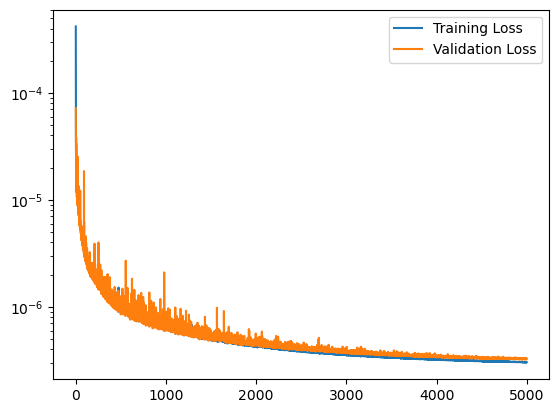

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
plt.semilogy(loss_list_train, label='Training Loss')
plt.semilogy(loss_list_valid, label='Validation Loss')
plt.legend()
plt.show()